In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

In [2]:
P = 3
Q = 7
resampl = P/Q
N = 4096
resamplQ = np.round(resampl * N) / N
print(resampl)
print(resamplQ)

0.42857142857142855
0.428466796875


700
300


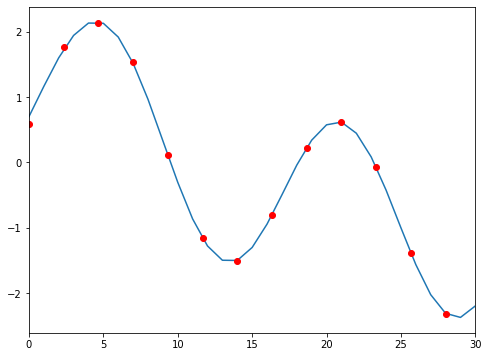

In [3]:
sig = ( np.cos(2*np.pi*1/50*np.arange(Q*100)) + 1.2*np.sin(2*np.pi*3/50*np.arange(Q*100)) - 
       .3*np.cos(2*np.pi*3.5/50*np.arange(Q*100)) )
sigResRef = signal.resample_poly(sig, P, Q)
print(len(sig))
print(len(sigResRef))
plt.subplots(figsize=(8, 6))
plt.plot(sig);
xRes = np.arange(P*100)* Q/P
plt.plot(xRes, sigResRef, 'ro');
plt.xlim(0, 30);

In [4]:
class Resampler(object):
    """ Resampler with nearest neighbor interpolation """
    
    def __init__(self, ratio, filtCoeffs, phasesNum, dtype=float, impl=('float', None)):
        """
            - ratio - initial resampling ratio, float
            - filtCoeffs - coefficients of filter, np.array
            - phasesNum - number of filter phases
            - dtype - type of input data (and hence output data)
            - impl - format of data for implementation, in [('float', None), ('int', cSc)]
                ('float', None) - process data in floating point format
                ('int', cSc) - process data in floating point format emulating integer format, where
                    - cSc - width of coefficients in 2'complement, integer
                    Filter coefficients in range [-1, 1) is multiplied by 2**(cSc - 1) and rounded to integer format
                    Input data must be integer (or float without fractional part)
        """
        self.iType = None
        self.initRatio = ratio
        self.setRatio(ratio)
        self.loadFilt(filtCoeffs, phasesNum)
        self.setImpl(impl)
        self.dtype = dtype
        self.dataTaps = np.zeros(int(len(self._filt)//self.phasesNum), self.dtype)
        self.dataBuffer = np.array([], dtype=self.dtype)
        self.phase = 0.
        self.wait = False
        self._waitCnt = 0
        
    def loadFilt(self, filt, phasesNum):
        """ Load filter coefficients.
            - filt - coefficients of lowpass FIR filter, array
            - phasesNum - quantity of phases in polyphase structure, integer
        """
        assert len(filt) % phasesNum == 0, "Number of filter coefficients must be multiple to phases quantity"
        self.phasesNum = phasesNum
        self._filt = filt
        if self.iType is not None:
            self.setImpl((self.iType, self.cSc))
    
    def setImpl(self, impl):
        """ Set data format of algorithm implementation
            - impl - format of data for implementation, in [('float', None), ('int', cSc)]
        """
        assert isinstance(impl, tuple) and len(impl) == 2, " Impl must be from set [('float', None), ('int', cSc)] "
        self.iType, self.cSc = impl
        if self.iType == 'float':
            self.polyFilt = self._filt.reshape(-1, self.phasesNum).T
        elif (self.iType == 'int') and (isinstance(self.cSc, int)):
            filtInt = np.round(self._filt * 2 ** (self.cSc - 1))
            assert (min(filtInt) >= -2 ** (self.cSc - 1)) and (max(filtInt) < 2 ** (self.cSc - 1)), (
                        " Filter coefficients are " +
                        " too large, they must be in range [-1, (2**(cSc-1) - 0.5) / 2**(cSc-1))] ")
            self.polyFilt = filtInt.reshape(-1, self.phasesNum).T
        else:
            assert False, " Impl must be from set [('float', None), ('int', cSc)] "

    @property
    def ratio(self):
        """ Current resampling ratio """
        return self._ratio
    
    @property
    def dPh(self):
        """ Current phase increment """
        return self._dPh
    
    def setRatio(self, val):
        """ Set ratio and appropriate phase increment
            - val - new value of resampling ratio
        """
        self._ratio = float(val)
        self._dPh = 1. / float(val)
        
    def setPhInc(self, val):
        """ Set phase increment and appropriate ratio
            - val - new value of phase increment
        """
        self._ratio = 1. / float(val)
        self._dPh = float(val)
    
    def reset(self):
        """ Reset resampler to initial state """
        self.setRatio(self.initRatio)
        self.dataTaps.fill(0.)
        self.dataBuffer = np.array([], dtype=self.dataBuffer.dtype)
        self.phase = 0.
        self.wait = False
        self._waitCnt = 0
        
    def _setWait(self, n):
        """ Wait for loading additional n samples in dataBuffer
            n - number of additional required samples
        """
        self._waitCnt = n
        self.wait = True
        
    def loadIntoBuffer(self, d):
        """ Load samples from d into buffer """
        len_ = 1 if np.isscalar(d) else len(d)
        if len_ >= self._waitCnt:
            self._waitCnt = 0
            self.wait = False
        else:
            self._waitCnt -= len_
        self.dataBuffer = np.append(self.dataBuffer, d)
        
    def step(self):
        """ Do one step in resampling data"""
        if self.wait:
            return None
        else:
            phInt, phFrac = np.divmod(self.phase, 1)
            phInt = int(phInt)
            if len(self.dataBuffer) < phInt:
                self._setWait(phInt - len(self.dataBuffer))
                return None
            else:
                if phInt > 0:
                    for ii in range(phInt):
                        self.dataTaps = np.roll(self.dataTaps, 1)
                        self.dataTaps[0] = self.dataBuffer[ii]
                    self.dataBuffer = np.delete(self.dataBuffer, np.arange(phInt))
                    self.phase -= phInt
                self.wait = False
                phInd = int(self.phase * self.phasesNum)
                res = np.sum(self.dataTaps * self.polyFilt[phInd, :])
                if self.iType == 'int':
                    if self.dataTaps.dtype == float:
                        res = res // 2 ** (self.cSc - 1)
                    else:  # complex number
                        res = (res.real // 2 ** (self.cSc - 1)) + 1j * (res.imag // 2 ** (self.cSc - 1))
                self.phase += self.dPh
                return res

In [5]:
taps = 16
nFilt = N * taps
hBWsig = .35
filt = signal.firwin2(nFilt, [0., .35/N, .5/N, 1.], [1., 1., 0., 0.])
filt = N*filt / np.sum(filt)
# w, h = signal.freqz(filt, 2**10)
# plt.plot(w/np.pi, 20*np.log10(np.abs(h)/np.max(np.abs(h))));
# plt.xlim(0, 0.02);

res = Resampler(resampl, filt, N, dtype=float, impl=('float', None))

In [6]:
res.loadIntoBuffer(sig)
val = 0
sigRes = np.array([])
while val is not None:
    val = res.step()
    if val is not None:
        sigRes = np.append(sigRes, val)
print(len(sigRes))

301


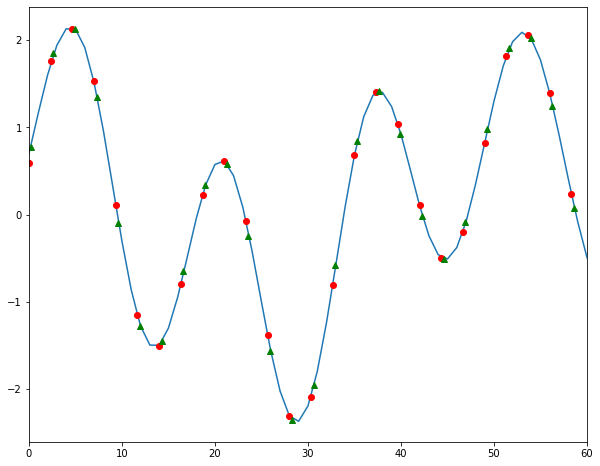

In [7]:
plt.subplots(figsize=(10, 8))
plt.plot(sig);
plt.plot(xRes, sigResRef, 'ro');
delayTrial = 3.3 # ???
delay = resampl*(taps//2) + delayTrial
plt.plot(xRes - delay, sigRes[1:], 'g^');
plt.xlim(0, 60);

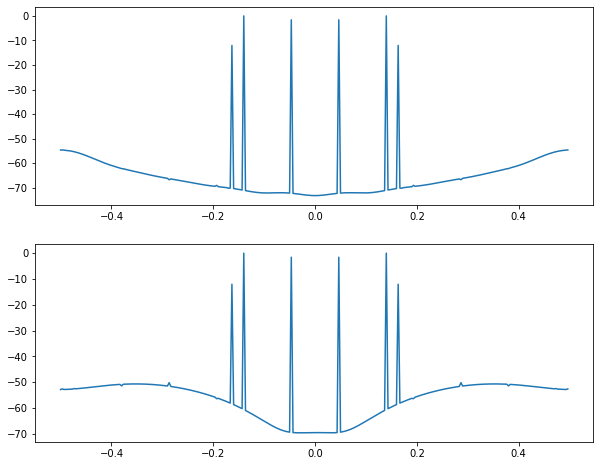

In [8]:
freqs = np.fft.fftshift( np.fft.fftfreq(len(sigResRef)) )
specRef = np.fft.fftshift( np.abs(np.fft.fft(sigResRef))**2 )
specRef = 10*np.log10(specRef / np.max(specRef))
spec = np.fft.fftshift( np.abs(np.fft.fft(sigRes[1:]))**2 )
spec = 10*np.log10(spec / np.max(spec))

plt.subplots(2, 1, figsize=(10, 8))
plt.subplot(211)
plt.plot(freqs, specRef);
plt.subplot(212)
plt.plot(freqs, spec);

### Test integer implementation

In [9]:
sig = ( np.exp(1j*2*np.pi*1/50*np.arange(Q*100)) + 1.2*np.exp(1j*2*np.pi*3/50*np.arange(Q*100)) - 
       .3*np.exp(1j*2*np.pi*3.5/50*np.arange(Q*100)) )
sigSc = 12
sigNorm = .99 * sig / max(sig) * (2**(sigSc-1)-1) / (2**(sigSc-1))
sigInt = np.round(sigNorm * 2**(sigSc-1))

impl = ('int', 16)
res = Resampler(resampl, filt, N, dtype=complex, impl=impl)
res.loadIntoBuffer(sigInt)
val = 0
sigResInt = np.array([])
while val is not None:
    val = res.step()
    if val is not None:
        sigResInt = np.append(sigResInt, val)
print(len(sigResInt))

301


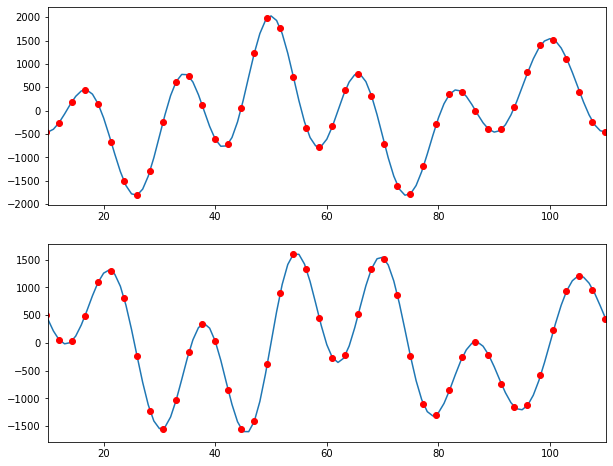

In [10]:
plt.subplots(2, 1, figsize=(10, 8))
plt.subplot(211)
plt.plot(sigInt.real);
plt.plot(xRes - delay, sigResInt[1:].real, 'ro');
plt.xlim(10, 110);
plt.subplot(212)
plt.plot(sigInt.imag);
plt.plot(xRes - delay, sigResInt[1:].imag, 'ro');
plt.xlim(10, 110);